In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, PolynomialFeatures, KBinsDiscretizer, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
# import skfuzzy as fuzz

In [3]:
df_train = pd.read_csv('rain_data.csv')
df_train.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,7,1017.400000,21.200000,20.6,19.9,19.400000,87.0,88.0,1.1,60.0,17.2,1
1,7,1019.500000,16.698171,16.9,15.8,15.400000,93.0,91.0,0.0,50.0,21.9,1
2,7,1024.017061,19.400000,16.1,14.6,9.527653,75.0,47.0,8.3,70.0,18.1,1
3,7,1013.400000,18.100000,17.8,16.9,16.800000,93.0,93.0,0.0,60.0,35.6,1
4,7,1021.800000,21.300000,18.4,15.2,9.600000,67.0,45.0,3.6,40.0,24.8,0


In [4]:
df_train = df_train.drop(columns=['day', 'maxtemp', 'mintemp', 'cloud', 'sunshine', 'winddirection'])

In [5]:
df_train.head()

,pressure,temparature,dewpoint,humidity,windspeed,rainfall
0,1017.400000,20.6,19.400000,87.0,17.2,1
1,1019.500000,16.9,15.400000,93.0,21.9,1
2,1024.017061,16.1,9.527653,75.0,18.1,1
3,1013.400000,17.8,16.800000,93.0,35.6,1
4,1021.800000,18.4,9.600000,67.0,24.8,0


In [6]:
# Cek minimum value, maximum value, average value dari setiap kolom numerik
df_train.describe().T[['min', 'max', 'mean']]

,min,max,mean
pressure,1005.900000,1024.017061,1013.868860
temparature,14.800000,30.371609,24.150178
dewpoint,9.527653,25.944154,20.268088
humidity,67.000000,93.000000,80.029273
windspeed,9.055915,39.500000,20.803651
rainfall,0.000000,1.000000,0.500000


In [69]:
def fuzzify4(value, 
             poor_min, poor_max,
             low_min, low_max,
             med_min, med_max,
             high_min, high_max):
    if value < poor_min:
        return "Poor"

    if value > high_max:
        return "High"

    if poor_min <= value <= poor_max:
        return "Poor"
    if low_min <= value <= low_max:
        return "Low"
    if med_min <= value <= med_max:
        return "Medium"
    if high_min <= value <= high_max:
        return "High"

    mids = {
        "Poor": (poor_min + poor_max) / 2,
        "Low": (low_min + low_max) / 2,
        "Medium": (med_min + med_max) / 2,
        "High": (high_min + high_max) / 2
    }
    
    distances = {k: abs(value - v) for k, v in mids.items()}
    return min(distances, key=distances.get)


In [70]:
def fuzzy_humidity(x):
    return fuzzify4(x, 70.1, 82.6, 78.6, 90.1, 86.3, 96.4, 91.7, 100.6)

def fuzzy_temparature(x):
    return fuzzify4(x, 22.4, 25.3, 24.0, 27.0, 25.7, 29.4, 27.9, 30.8)

def fuzzy_pressure(x):
    return fuzzify4(x, 1001, 1010, 1005, 1012, 1007, 1014, 1009, 1016)

def fuzzy_windspeed(x):
    return fuzzify4(x, 0.7, 4.9, 4.7, 12.3, 11.7, 21.4, 20.4, 44.1)

def fuzzy_dewpoint(x):
    return fuzzify4(x, 20.9, 24.0, 22.8, 25.0, 23.8, 26.3, 25.0, 26.8)

In [71]:
df_train["humidity_f"] = df_train["humidity"].apply(fuzzy_humidity)
df_train["temparature_f"] = df_train["temparature"].apply(fuzzy_temparature)
df_train["pressure_f"] = df_train["pressure"].apply(fuzzy_pressure)
df_train["windspeed_f"] = df_train["windspeed"].apply(fuzzy_windspeed)
df_train["dewpoint_f"] = df_train["dewpoint"].apply(fuzzy_dewpoint)

In [72]:
df_train.head()

,pressure,temparature,dewpoint,humidity,windspeed,rainfall,humidity_f,temparature_f,pressure_f,windspeed_f,dewpoint_f
0,1017.400000,20.6,19.400000,87.0,17.2,1,Low,Poor,High,Medium,Poor
1,1019.500000,16.9,15.400000,93.0,21.9,1,Medium,Poor,High,High,Poor
2,1024.017061,16.1,9.527653,75.0,18.1,1,Poor,Poor,High,Medium,Poor
3,1013.400000,17.8,16.800000,93.0,35.6,1,Medium,Poor,Medium,High,Poor
4,1021.800000,18.4,9.600000,67.0,24.8,0,Poor,Poor,High,High,Poor


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      1899
           1       0.81      0.63      0.71      1899

    accuracy                           0.74      3798
   macro avg       0.75      0.74      0.74      3798
weighted avg       0.75      0.74      0.74      3798



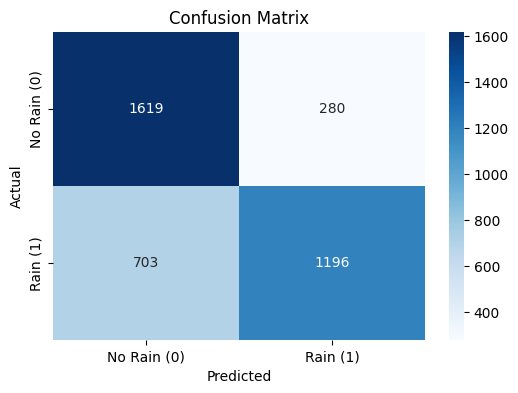

In [73]:
feature_cols = ['humidity_f', 'temparature_f', 'pressure_f', 'windspeed_f', 'dewpoint_f'] 
target_col = 'rainfall' 

rule_cols = feature_cols + [target_col]

X = df_train[feature_cols]
y = df_train[target_col]
X_encoded = pd.get_dummies(X, columns=feature_cols)

dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=5) 
dt_classifier.fit(X_encoded, y)

tree_rules = export_text(
    dt_classifier, 
    feature_names=list(X_encoded.columns), 
    class_names=['No Rain (0)', 'Rain (1)']
)

rules_file_name = 'decision_tree_rules.txt'
with open(rules_file_name, 'w') as f:
    f.write(tree_rules)

y_pred = dt_classifier.predict(X_encoded)
print("Classification Report:")
print(classification_report(y, y_pred))

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Rain (0)', 'Rain (1)'], yticklabels=['No Rain (0)', 'Rain (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()